In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir_4_5_5 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.5_linear_scale-up_etc/ciff_sam/2021_11_23_17_59_09/count_data/'
output_dir_4_5_6 ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.6_no_x_factor/ciff_sam/2021_11_29_14_01_14/count_data/'

In [5]:
def calculate_wasting_transition_rates(output_dir,
                                      ages, transition, source_state, 
                                      groupby_cols, time_to_response=False):
    wasting_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv').drop(columns='Unnamed: 0')
    wasting_transitions = pd.read_csv(output_dir +'wasting_transition_count.csv').drop(columns='Unnamed: 0')
    transition = (wasting_transitions.loc[(wasting_transitions.age.isin(ages))
                                         & (wasting_transitions.measure==transition)]
                  .groupby(groupby_cols).sum())
    pt = (wasting_pt.loc[(wasting_pt.age.isin(ages))
                       & (wasting_pt.cause==source_state)]
          .groupby(groupby_cols).sum())
    transition_rate = transition / pt
    if time_to_response==True:
        transition_rate = 365 / transition_rate
    transition_rate = (transition_rate.groupby([c for c in groupby_cols if c != 'input_draw'])
                       .describe(percentiles=[0.025,0.975]))['value']
    return transition_rate

In [42]:
ages = ['6-11_months', '12_to_23_months', '2_to_4']

In [35]:
# i1 (MAM to SAM) in 4.5.5 with x-factor
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count', 
                                   'moderate_acute_malnutrition', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,1.881085,0.166318,1.611623,1.646078,1.905576,2.143461,2.190107
sqlns,12.0,1.893940,0.167979,1.622029,1.656783,1.915445,2.162153,2.210424
wasting_treatment,12.0,1.886841,0.166193,1.616425,1.651128,1.908292,2.150547,2.197140


In [11]:
#i1 (MAM to SAM) in 4.5.6 without x-factor
calculate_wasting_transition_rates(output_dir_4_5_6, ages, 
                                   'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count', 
                                   'moderate_acute_malnutrition', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,1.478817,0.131275,1.265059,1.292181,1.499533,1.691137,1.727720
sqlns,12.0,1.484804,0.131391,1.271335,1.298164,1.505024,1.699267,1.735679
wasting_treatment,12.0,1.481728,0.131269,1.267405,1.294545,1.504089,1.694371,1.730749


i1 incidence rate from MAM to SAM is higher in the x-factor run than in the run without the x-factor. This could be driving the overestimation of SAM and underestimation of MAM

So let's check what it looks like stratified by the x-factor exposure

In [76]:
x_factor_rr = 3.16
x_factor_exposure = 0.5
x_factor_paf = (((x_factor_rr * x_factor_exposure + 1 * (1 - x_factor_exposure)) - 1) 
                / (x_factor_rr * x_factor_exposure + 1 * (1 - x_factor_exposure)))
x_factor_paf

0.5192307692307693

In [77]:
# what unexposed to x-factor transition rate should be based on i1 from 4.5.6 (without x-factor)
1.478817 * (1 - x_factor_paf)

0.7109697115384614

In [78]:
# what exposed to x-factor transition rate should be based on i1 from 4.5.6 (without x-factor)
1.478817 * (1 - x_factor_paf) * x_factor_rr

2.246664288461538

In [36]:
# i1 (MAM to SAM) in 4.5.5 with x-factor by x-factor exposure
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count', 
                                   'moderate_acute_malnutrition', 
                                      ['input_draw','scenario','x_factor'], time_to_response=False)


# these look pretty close to what they should be...

count      mean       std       min      2.5%  \
scenario          x_factor                                                  
baseline          cat1       12.0  2.263399  0.200477  1.939847  1.980745   
                  cat2       12.0  0.696571  0.060926  0.600500  0.610332   
sqlns             cat1       12.0  2.273005  0.202231  1.946346  1.987781   
                  cat2       12.0  0.697375  0.061679  0.598481  0.608116   
wasting_treatment cat1       12.0  2.268927  0.200079  1.944074  1.985067   
                  cat2       12.0  0.697917  0.061723  0.600144  0.610025   

                                 50%     97.5%       max  
scenario          x_factor                                
baseline          cat1      2.290835  2.581116  2.642229  
                  cat2      0.704319  0.797671  0.809668  
sqlns             cat1      2.296712  2.595219  2.657701  
                  cat2      0.705079  0.798211  0.809414  
wasting_treatment cat1      2.292664  2.586029  2.646818  
                  cat2      0.707057  0.799459  0.811886

In [41]:
# but exposure-weighted incidence does not match overall incidence from 4.5.5 (1.88)
# instead it matches what we would expect at 1.47 from 4.5.6
# what is going on here??

2.263399 * 0.5 + 0.696571 * 0.5

1.479985

In [ ]:
# seems like we have too many x-factor exposed simulants transitioning from mam to sam then...
# so let's check x-factor exposure status

In [44]:
wasting_pt = pd.read_csv(output_dir_4_5_5 +'wasting_state_person_time.csv').drop(columns='Unnamed: 0')
wasting_transitions = pd.read_csv(output_dir_4_5_5 +'wasting_transition_count.csv').drop(columns='Unnamed: 0')

In [79]:
# let's check x-factor exposure 
a = wasting_pt.groupby(['input_draw','scenario','x_factor']).sum()#.groupby(['scenario','cause','x_factor']).mean()
b = wasting_pt.groupby(['input_draw','scenario']).sum()
(a/b).groupby(['scenario','x_factor']).describe(percentiles=[0.025,0.975])['value']
# looks to be ~ 50% overall

count      mean       std       min      2.5%  \
scenario          x_factor                                                  
baseline          cat1       12.0  0.500014  0.001291  0.498228  0.498308   
                  cat2       12.0  0.499986  0.001291  0.496922  0.497556   
sqlns             cat1       12.0  0.500046  0.001294  0.498268  0.498346   
                  cat2       12.0  0.499954  0.001294  0.496883  0.497520   
wasting_treatment cat1       12.0  0.500033  0.001291  0.498254  0.498331   
                  cat2       12.0  0.499967  0.001291  0.496910  0.497541   

                                 50%     97.5%       max  
scenario          x_factor                                
baseline          cat1      0.500015  0.502444  0.503078  
                  cat2      0.499985  0.501692  0.501772  
sqlns             cat1      0.500046  0.502480  0.503117  
                  cat2      0.499954  0.501654  0.501732  
wasting_treatment cat1      0.500031  0.502459  0.503090  
                  cat2      0.499969  0.501669  0.501746

In [80]:
# now let's check by wasting state
a = wasting_pt.groupby(['input_draw','scenario','cause','x_factor']).sum()
b = wasting_pt.groupby(['input_draw','scenario','cause']).sum()
(a/b).groupby(['scenario','cause','x_factor']).describe(percentiles=[0.025,0.975])['value']

count      mean  \
scenario          cause                        x_factor                    
baseline          mild_child_wasting           cat1       12.0  0.540665   
                                               cat2       12.0  0.459335   
                  moderate_acute_malnutrition  cat1       12.0  0.786749   
                                               cat2       12.0  0.213251   
                  severe_acute_malnutrition    cat1       12.0  0.929364   
                                               cat2       12.0  0.070636   
                  susceptible_to_child_wasting cat1       12.0  0.445799   
                                               cat2       12.0  0.554201   
sqlns             mild_child_wasting           cat1       12.0  0.543880   
                                               cat2       12.0  0.456120   
                  moderate_acute_malnutrition  cat1       12.0  0.794043   
                                               cat2       12.0  0.205957   
                  severe_acute_malnutrition    cat1       12.0  0.933202   
                                               cat2       12.0  0.066798   
                  susceptible_to_child_wasting cat1       12.0  0.449654   
                                               cat2       12.0  0.550346   
wasting_treatment mild_child_wasting           cat1       12.0  0.542704   
                                               cat2       12.0  0.457296   
                  moderate_acute_malnutrition  cat1       12.0  0.789862   
                                               cat2       12.0  0.210138   
                  severe_acute_malnutrition    cat1       12.0  0.931195   
                                               cat2       12.0  0.068805   
                  susceptible_to_child_wasting cat1       12.0  0.448208   
                                               cat2       12.0  0.551792   

                                                              std       min  \
scenario          cause                        x_factor                       
baseline          mild_child_wasting           cat1      0.001524  0.537736   
                                               cat2      0.001524  0.456386   
                  moderate_acute_malnutrition  cat1      0.002943  0.782575   
                                               cat2      0.002943  0.208621   
                  severe_acute_malnutrition    cat1      0.001918  0.926198   
                                               cat2      0.001918  0.066950   
                  susceptible_to_child_wasting cat1      0.001264  0.443889   
                                               cat2      0.001264  0.551628   
sqlns             mild_child_wasting           cat1      0.001545  0.540541   
                                               cat2      0.001545  0.453317   
                  moderate_acute_malnutrition  cat1      0.002732  0.789916   
                                               cat2      0.002732  0.201515   
                  severe_acute_malnutrition    cat1      0.002052  0.930354   
                                               cat2      0.002052  0.062651   
                  susceptible_to_child_wasting cat1      0.001218  0.448134   
                                               cat2      0.001218  0.547771   
wasting_treatment mild_child_wasting           cat1      0.001448  0.539833   
                                               cat2      0.001448  0.454428   
                  moderate_acute_malnutrition  cat1      0.002817  0.785909   
                                               cat2      0.002817  0.205759   
                  severe_acute_malnutrition    cat1      0.002041  0.928392   
                                               cat2      0.002041  0.064996   
                  susceptible_to_child_wasting cat1      0.001222  0.446385   
                                               cat2      0.001222  0.549320   

                         

Text(0.5, 1.0, 'X-factor exposure by wasting state')

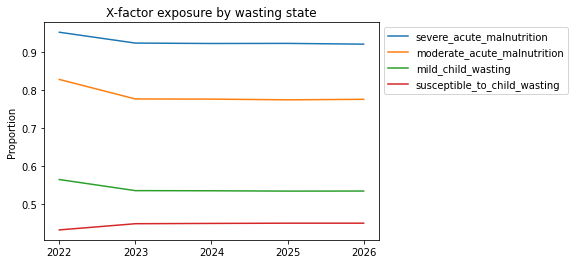

In [69]:
a = wasting_pt.groupby(['input_draw','scenario','cause','year','x_factor']).sum()#.groupby(['scenario','cause','x_factor']).mean()
b = wasting_pt.groupby(['input_draw','scenario','cause','year']).sum()
p = (a/b).groupby(['scenario','cause','year','x_factor']).describe(percentiles=[0.025,0.975])['value'].reset_index()
for cause in ['severe_acute_malnutrition',
             'moderate_acute_malnutrition',
             'mild_child_wasting',
             'susceptible_to_child_wasting']:
    plt.plot(p.loc[(p.scenario=='baseline')&(p.x_factor=='cat1')&(p.cause==cause)]['year'],
            p.loc[(p.scenario=='baseline')&(p.x_factor=='cat1')&(p.cause==cause)]['mean'],
            label=cause)
plt.legend(bbox_to_anchor=[1,1])
plt.xticks(p.year.unique())
plt.ylabel('Proportion')
plt.title('X-factor exposure by wasting state')

In [95]:
p.loc[(p.x_factor=='cat1')&(p.cause=='moderate_acute_malnutrition')]

,scenario,cause,year,x_factor,count,mean,std,min,2.5%,50%,97.5%,max
10,baseline,moderate_acute_malnutrition,2022,cat1,12.0,0.828696,0.002852,0.824956,0.825041,0.828271,0.832153,0.832193
12,baseline,moderate_acute_malnutrition,2023,cat1,12.0,0.777192,0.004474,0.769114,0.770330,0.776821,0.785219,0.786256
14,baseline,moderate_acute_malnutrition,2024,cat1,12.0,0.776827,0.003655,0.771794,0.771964,0.776944,0.782554,0.783041
16,baseline,moderate_acute_malnutrition,2025,cat1,12.0,0.774968,0.003175,0.771205,0.771437,0.773981,0.780012,0.780230
18,baseline,moderate_acute_malnutrition,2026,cat1,12.0,0.776255,0.004076,0.769301,0.769539,0.776645,0.781801,0.782312
50,sqlns,moderate_acute_malnutrition,2022,cat1,12.0,0.828696,0.002852,0.824956,0.825041,0.828271,0.832153,0.832193
52,sqlns,moderate_acute_malnutrition,2023,cat1,12.0,0.778578,0.004337,0.770601,0.771749,0.778878,0.786296,0.787387
54,sqlns,moderate_acute_malnutrition,2024,cat1,12.0,0.782804,0.003552,0.777879,0.778096,0.782344,0.788620,0.789647
56,sqlns,moderate_acute_malnutrition,2025,cat1,12.0,0.785756,0.003665,0.778241,0.778924,0.786577,0.790966,0.791388
58,sqlns,moderate_acute_malnutrition,2026,cat1,12.0,0.789701,0.003607,0.783296,0.783811,0.789309,0.794735,0.795058


In [ ]:
# so let's test some different exposures/PAFs...

In [115]:
def print_incidence_rates(x_factor_exposure_for_paf_calculation, 
                   x_factor_exposure_for_overall_rate_calculation,
                   overall_transition_value_without_x_factor):
    x_factor_rr = 3.16
    x_factor_paf = (((x_factor_rr * x_factor_exposure_for_paf_calculation + 1 * (1 - x_factor_exposure_for_paf_calculation)) - 1) 
                    / (x_factor_rr * x_factor_exposure_for_paf_calculation + 1 * (1 - x_factor_exposure_for_paf_calculation)))
    unexposed_rate = overall_transition_value_without_x_factor * (1 - x_factor_paf)
    exposed_rate = unexposed_rate * x_factor_rr
    overall_rate = unexposed_rate * (1 - x_factor_exposure_for_overall_rate_calculation) + exposed_rate * x_factor_exposure_for_overall_rate_calculation
    print('unexposed_rate: ',unexposed_rate,'\nexposed_rate: ',exposed_rate,'\noverall_rate: ',overall_rate)

In [116]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.5,
              overall_transition_value_without_x_factor=1.478817)

unexposed_rate:  0.7109697115384614 
exposed_rate:  2.246664288461538 
overall_rate:  1.4788169999999998


In [117]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.77,
              overall_transition_value_without_x_factor=1.478817)

unexposed_rate:  0.7109697115384614 
exposed_rate:  2.246664288461538 
overall_rate:  1.8934545357692305


In [118]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.77, 
               x_factor_exposure_for_overall_rate_calculation=0.77,
              overall_transition_value_without_x_factor=1.478817)

unexposed_rate:  0.55527823670772 
exposed_rate:  1.7546792279963954 
overall_rate:  1.478817


# look at mild to mam transition too for consistency

In [99]:
# i2 (mild to MAM) in 4.5.5 with x-factor
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'mild_child_wasting_to_moderate_acute_malnutrition_event_count', 
                                   'mild_child_wasting', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,2.275872,0.061230,2.153593,2.160756,2.285441,2.354328,2.354587
sqlns,12.0,2.098197,0.052997,1.981086,1.991580,2.120699,2.144345,2.144975
wasting_treatment,12.0,2.283400,0.060755,2.161666,2.168929,2.292037,2.360283,2.360592


In [101]:
# i2 (mild to MAM) in 4.5.6 without x-factor
calculate_wasting_transition_rates(output_dir_4_5_6, ages, 
                                   'mild_child_wasting_to_moderate_acute_malnutrition_event_count', 
                                   'mild_child_wasting', 
                                      ['input_draw','scenario'], time_to_response=False)

,count,mean,std,min,2.5%,50%,97.5%,max
scenario,,,,,,,,
baseline,12.0,2.303764,0.062578,2.175886,2.186362,2.306274,2.383482,2.384150
sqlns,12.0,2.114371,0.053588,1.994793,2.007124,2.137583,2.164380,2.166067
wasting_treatment,12.0,2.304367,0.062428,2.176659,2.187041,2.306845,2.383756,2.384776


In [119]:
# i2 (mild to MAM) in 4.5.5 with x-factor
calculate_wasting_transition_rates(output_dir_4_5_5, ages, 
                                   'mild_child_wasting_to_moderate_acute_malnutrition_event_count', 
                                   'mild_child_wasting', 
                                      ['input_draw','scenario','x_factor'], time_to_response=False)

count      mean       std       min      2.5%  \
scenario          x_factor                                                  
baseline          cat1       12.0  3.501611  0.093468  3.308654  3.321715   
                  cat2       12.0  1.106286  0.030013  1.047732  1.052163   
sqlns             cat1       12.0  3.214266  0.083252  3.029249  3.047006   
                  cat2       12.0  1.014440  0.025445  0.958660  0.964321   
wasting_treatment cat1       12.0  3.503163  0.093480  3.310540  3.323202   
                  cat2       12.0  1.106623  0.029994  1.048007  1.052401   

                                 50%     97.5%       max  
scenario          x_factor                                
baseline          cat1      3.513056  3.620910  3.621660  
                  cat2      1.106123  1.145240  1.146727  
sqlns             cat1      3.252355  3.284248  3.285309  
                  cat2      1.022157  1.039790  1.040039  
wasting_treatment cat1      3.513490  3.621671  3.622941  
                  cat2      1.106970  1.145438  1.146793

In [120]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.5,
              overall_transition_value_without_x_factor=2.303764)

unexposed_rate:  1.107578846153846 
exposed_rate:  3.4999491538461536 
overall_rate:  2.3037639999999997


In [121]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.5, 
               x_factor_exposure_for_overall_rate_calculation=0.54,
              overall_transition_value_without_x_factor=2.303764)

unexposed_rate:  1.107578846153846 
exposed_rate:  3.4999491538461536 
overall_rate:  2.3994588123076923


In [123]:
print_incidence_rates(x_factor_exposure_for_paf_calculation=0.54, 
               x_factor_exposure_for_overall_rate_calculation=0.54,
              overall_transition_value_without_x_factor=2.303764)

unexposed_rate:  1.0634065731166913 
exposed_rate:  3.3603647710487445 
overall_rate:  2.303764
